In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from utils import plot_images, read_mnist_data
from tfops import fc, conv, deconv, flatten, inflate
from time import time
from os.path import exists

In [2]:
data, _ = read_mnist_data()

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Data shapes:
Training - x: (55000, 784), y:(55000, 10)
Test - x: (10000, 784), y:(10000, 10)
Validation - x: (5000, 784), y:(5000, 10)


In [31]:
tf.reset_default_graph()

z_dim = 32

with tf.name_scope('inputs'):
    x = tf.placeholder(tf.float32, (None, 784), name='x')
    phase_train = tf.placeholder_with_default(True, [], name='phase_train')
    
with tf.name_scope('encoder'):
    x_image = inflate(x, (28, 28))
    z = conv(x_image, 16)
    z = conv(z, 32)
    z = flatten(z)
    with tf.name_scope('latent-space'):
        z_mean = fc(z, z_dim, 'None', 'z_mean')
        z_std = fc(z, z_dim, 'None', 'z_std')
        noise = tf.placeholder(tf.float32, (None, z_dim), name='noise')
        z = noise * z_std + z_mean
    
with tf.name_scope('decoder'):
    x_gen = fc(z, 32 * 7 * 7)
    x_gen = inflate(x_gen, (7, 7))
    x_gen = deconv(x_gen, 16, out_shape=(-1, 14, 14, -1))
    x_gen = deconv(x_gen, 1, out_shape=(-1, 28, 28, -1))
    x_gen = flatten(x_gen)

with tf.name_scope('optimizer'):
    generation_loss = tf.reduce_mean((x_gen - x)**2, name='generation_loss')
    tf.summary.scalar('generation_loss', generation_loss)
    
    latent_loss = 0.5 * tf.reduce_sum(tf.square(z_mean) + tf.square(z_std) - tf.log(tf.square(z_std)) - 1, 1)
    tf.summary.scalar('latent_loss', tf.reduce_mean(latent_loss))
    
    loss = generation_loss + 1e-3 * latent_loss
    tf.summary.scalar('loss', generation_loss + 1e-3 * tf.reduce_mean(latent_loss))
    
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)
    
summ = tf.summary.merge_all()

In [32]:
def plot_reconstructions(sess, std=0, bw=(0, 1)):
    img_idx = np.random.randint(0, data.validation.num_examples, 11)
    valid_img = data.validation.images[img_idx] * (1 + np.random.randn(11, 784) * std)
    valid_img_reconstruction = sess.run(x_gen, {x: valid_img, noise: np.random.randn(11, z_dim)})
    plot_images(valid_img)
    
    valid_img_reconstruction[valid_img_reconstruction >= bw[1]] = 1
    valid_img_reconstruction[valid_img_reconstruction < bw[0]] = 0
    plot_images(valid_img_reconstruction)

In [33]:
def plot_generated_images(sess):
    epsilon = np.random.randn(11, z_dim)
    generated_img = sess.run(x_gen, {z: epsilon})
    plot_images(generated_img)

In [12]:
batch_size = 256
def optimize(epochs=1):
    batches_per_epoch = int(data.train.num_examples / batch_size)
    start_time = time()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        writer = tf.summary.FileWriter('output/DCVAE')
        writer.add_graph(tf.get_default_graph())
        
        saver = tf.train.Saver()
        
        for epoch in range(epochs):
            for i in range(batches_per_epoch):
                x_batch, _ = data.train.next_batch(batch_size)
                epsilon = np.random.randn(batch_size, z_dim)
                sess.run(optimizer, {x: x_batch, noise: epsilon})
                
                print("{} / {} ({}%) -- {}s".format(epoch + 1, epochs, int(((i+1)/(batches_per_epoch * epochs) + epoch/epochs) * 100), np.round(time()-start_time, 2)), end='\r')
                
                if i % 100 == 0:
                    writer.add_summary(sess.run(summ, {x: x_batch, noise: epsilon}), global_step=epoch * batches_per_epoch + i)
                
            plot_reconstructions(sess)

        writer.close()
        total_time = time() - start_time
        print("Time per epoch: {}s, Time per iteration: {}s, Time per example: {}s".format(total_time / epochs, total_time / (epochs * batches_per_epoch), total_time / (epochs * batches_per_epoch * batch_size)))
        
        saver.save(sess, 'checkpoints/DCVAE/DCVAE', write_meta_graph=False)

INFO:tensorflow:Restoring parameters from checkpoints/DCVAE/DCVAE
Reconstructions:


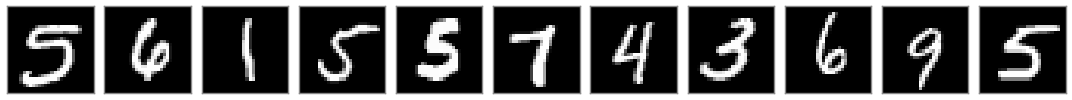

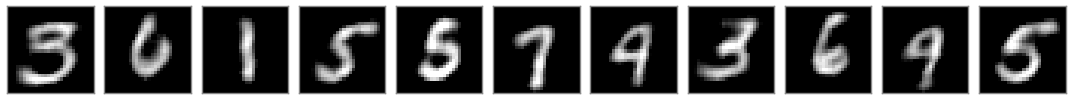

Generation:


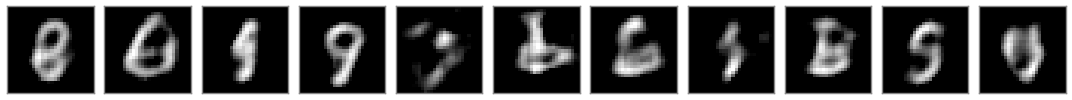

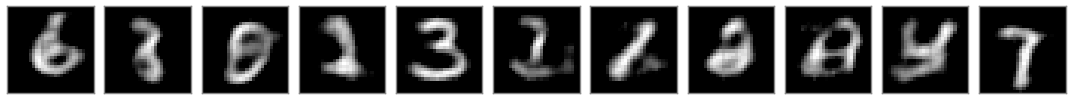

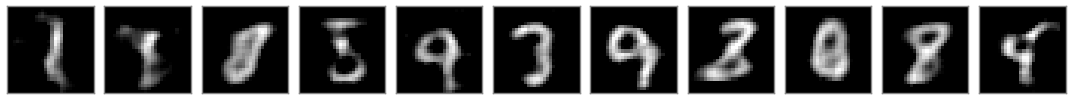

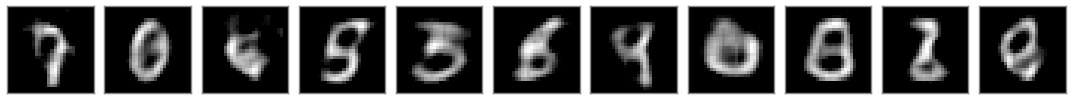

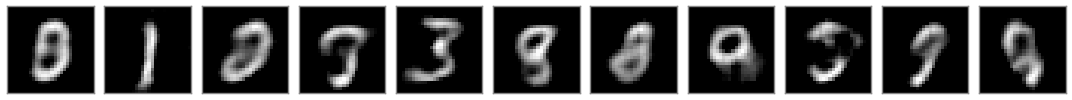

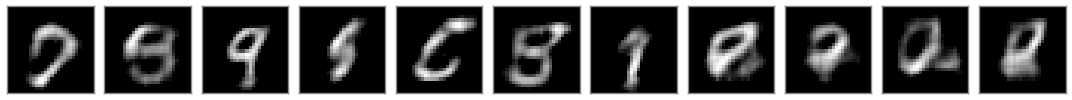

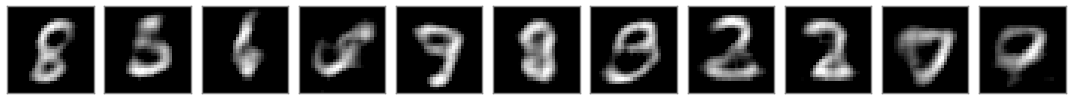

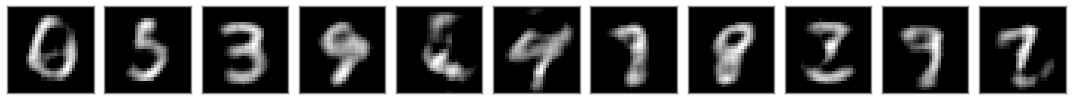

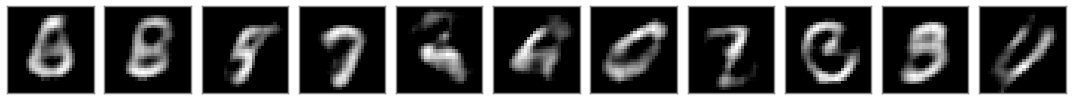

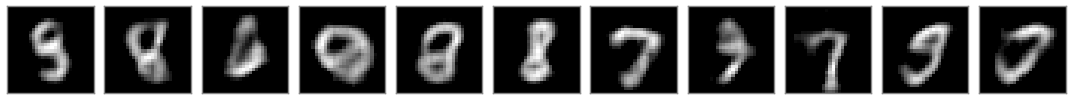

In [35]:
if exists('checkpoints/DCVAE/DCVAE.data-00000-of-00001'):
    with tf.Session() as sess:
        saver = tf.train.Saver()
        saver.restore(sess, 'checkpoints/DCVAE/DCVAE')
        
        print("Reconstructions:")
        plot_reconstructions(sess)
        
        print("Generation:")
        for _ in range(10):
            plot_generated_images(sess)
else:
    optimize(30)